# Projeto 1 - Status de Requisicoes

## Componentes

- Raphael Ramos
- Ernane Ferreira

## Dataset

Usamos um dos datasets das Requisições de Materiais no grupo de Materiais, dos Dados Abertos da UFRN. Abaixo uma descrição dele

In [986]:
# Importa a biblioteca pandas com o alias 'pd'
import pandas as pd

# Lê um arquivo CSV como delimitador ;
rm = pd.read_csv('data/all_data.csv', delimiter=',')

# Exibe as primeiras linhas do DataFrame 'rm' para visualizar os dados
rm.head()

,numero,ano,requisicao,data,id_unidade_requisitante,unidade_requisitante,id_unidade_custo,unidade_custo,observacoes,grupo_material,convenio,status,tipo_requisicao,almoxarifado,valor
0,2469,1998,2469/1998,29/12/1998,283,EDITORA UNIVERSITÁRIA,283,EDITORA UNIVERSITÁRIA,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 13,80"
1,2468,1998,2468/1998,29/12/1998,1463,RESIDENCIAS UNIVERSITÁRIAS,1463,RESIDENCIAS UNIVERSITÁRIAS,NaN,GAS ENGARRAFADO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 84,00"
2,2470,1998,2470/1998,29/12/1998,253,NÚCLEO PERMANENTE DE CONCURSOS,253,NÚCLEO PERMANENTE DE CONCURSOS,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 4,60"
3,2471,1998,2471/1998,29/12/1998,285,HOSPITAL UNIVERSITARIO ANA BEZERRA,285,HOSPITAL UNIVERSITARIO ANA BEZERRA,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 34,50"
4,2460,1998,2460/1998,28/12/1998,1423,DIRETORIA DE LOGÍSTICA - PROAD,1423,DIRETORIA DE LOGÍSTICA - PROAD,NaN,MATERIAL DE LIMPEZA E PRODUTOS DE HIGIENIZACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 86,56"


## Contexto

Quando uma unidade precisa de algum material, ela abre uma requisição para o almoxarifado. Nessa requisição, deve ter o preço estimado desse material e a unidade que vai custear esse material. Assim, o almoxarifado pode aprová-la e dar início a ordem de compra.

## Ideia

Neste dataset, queremos que, dada uma requisição, prever ele vai ser negada ou autorizada pelo almoxarifado. Além disso, investigar qual perfil das requisições que têm mais chances de serem aprovadas.

## Preprocessamento

Como esse dataset possui registros de devolução e requisições que envolvem serviços, vamos considerar apenas as requisições de material da instituição

In [987]:
# Filtre apenas as requisicoes de materiais
df = rm[rm['tipo_requisicao'] == 'REQUISIÇÃO DE MATERIAL']

Algumas colunas em nada agregam ao nosso objetivo, portanto vamos retirá-las

In [988]:
# Retirar colunas
df = df.drop([
    'numero',
    'ano',
    'requisicao',
    'data',
    'observacoes',
    'grupo_material',
    'tipo_requisicao',
    'unidade_custo',
    'id_unidade_custo',
    'id_unidade_requisitante'
], axis=1)

A coluna status é multivalorada, mas apenas nos importa saber se a requisição foi negada ou não.

In [989]:
# Ter noção de quais status estão presentes
# print(sorted(set(df['status'])))

# Filtrar apenas requisições negadas, autorizadas e que tiveram a compra efetuada
df = df[df['status'].isin(['NEGADA', 'AUTORIZADA', 'COMPRA', 'LIQUIDADA', 'EM_LIQUIDACAO'])]

# Substituir 'NEGADA' por 1 e outros valores por 0 na coluna 'status'
df['status'] = df['status'].apply(lambda x: 1 if x == 'NEGADA' else 0)

# Ter noção de quais unidades estão presentes
# sorted(set(df['unidade_requisitante']))

Vamos nos deter apenas as unidades requisitantes administrativas dos departamentos da UFRN

In [990]:
# Filtrar unidades requisitantes por tipo
df = df[(
    df['unidade_requisitante'].str.startswith('ADMINISTRAÇÃO') |
    df['unidade_requisitante'].str.startswith('DIRETORIA') |
    df['unidade_requisitante'].str.startswith('SECRETARIA') |
    df['unidade_requisitante'].str.startswith('DEPARTAMENTO') |
    df['unidade_requisitante'].str.startswith('COORDENAÇÃO') |
    df['unidade_requisitante'].str.startswith('ALMOXARIFADO') |
    df['unidade_requisitante'].str.startswith('ASSESORIA') |
    df['unidade_requisitante'].str.startswith('ASSISTÊNCIA') |
    df['unidade_requisitante'].str.startswith('BIBLIOTECA') |
    df['unidade_requisitante'].str.startswith('PRÓ-REITORIA') |
    df['unidade_requisitante'].str.startswith('HUOL')
)]

# Função para realizar a substituição
def categorize_request_unit(valor):
    if valor.startswith("ADMINISTRAÇÃO"):
        return 0
    elif valor.startswith("DIRETORIA"):
        return 1
    elif valor.startswith("SECRETARIA"):
        return 2
    elif valor.startswith("DEPARTAMENTO"):
        return 3
    elif valor.startswith("COORDENAÇÃO"):
        return 4
    elif valor.startswith("ALMOXARIFADO"):
        return 5
    elif valor.startswith("ASSESSORIA"):
        return 6
    elif valor.startswith("ASSISTÊNCIA"):
        return 7
    elif valor.startswith("BIBLIOTECA"):
        return 8
    elif valor.startswith("PRÓ-REITORIA"):
        return 9
    elif valor.startswith("HUOL"):
        return 10
    else:
        # Se nenhuma das condições for atendida, mantenha o valor original
        return valor  

# Aplicar a função à coluna "unidade_requisitante" e criar uma nova coluna com os valores substituídos
df['unidade_requisitante'] = df['unidade_requisitante'].apply(categorize_request_unit)

As colunas convenio e almoxarifado são interessantes, mas são categóricas. Portanto, precisão ser tratadas. Abaixo uma função que facilita esse trabalho

In [991]:
from sklearn.preprocessing import LabelEncoder

def categorize(dataframe, column):
    """
    Recebe um dataframe e a coluna com os dados categóricos que se quer rotular

    Args:
        dataframe (object DataFrame)
        column (string)
    """
    # Identificar categorias de column
    data = {category for category in set(dataframe[column])} 
    
    # Traduzir cada categoria para numeros
    label_encoder = LabelEncoder()
    
    # Atualiza no dataframe
    dataframe[column] = label_encoder.fit_transform(dataframe[column])
    
    # Obtenha as categorias originais e seus rótulos numéricos
    categories = label_encoder.classes_
    labels = label_encoder.transform(categories)

    # Visualizar mapeamento
    display(pd.DataFrame({'Categoria':categories, 'Rótulo Numérico': labels}))

In [992]:
categorize(df, 'convenio')

,Categoria,Rótulo Numérico
0,False,0
1,True,1


In [993]:
categorize(df, 'almoxarifado')

,Categoria,Rótulo Numérico
0,ALMOXARIFADO - CB,0
1,ALMOXARIFADO - CCET,1
2,ALMOXARIFADO - CCHLA,2
3,ALMOXARIFADO - CCHLA - PORTARIA 097/2014,3
4,ALMOXARIFADO - CCS,4
5,ALMOXARIFADO - CCSA,5
6,ALMOXARIFADO - CT,6
7,ALMOXARIFADO CENTRAL,7
8,ALMOXARIFADO DE MATERIAIS DE MANUTENÇÃO DE IMÓ...,8
9,HUOL - ALMOXARIFADO GERAL,9


A coluna `valor` precisa ser transformada em valores decimais

In [994]:
import re

rgx_remove_trash = r'R\$|\s'
rgx_only_last_point = r'\.(?=[^.]*\.)'

df.loc[:,'valor'] = df['valor'].apply(lambda value: re.sub(rgx_only_last_point, '', re.sub(rgx_remove_trash, '', value).replace(',', '.')))
df.loc[:,'valor'] = df['valor'].astype(float)

Abaixo está o dataset após as remoções e categorização das colunas que possuem dados não contínuos

In [995]:
df

,unidade_requisitante,convenio,status,almoxarifado,valor
39292,8,0,0,10,49330.04
40717,3,0,0,10,1194.06
40802,3,0,0,10,1232.22
40814,3,0,0,10,1477.8
40870,8,0,0,10,25382.8
...,...,...,...,...,...
617627,9,0,0,10,4834.5
620056,0,0,1,7,1053.44
621466,1,0,1,8,3695.13
621869,5,0,1,7,600.0


Observe que os valores (em reais) das requisições são muito discrepantes em relação as numerações das categorias que fizemos. Podemos ter uma ideia dessa discrepância ao visualizar um boxplot de cada coluna

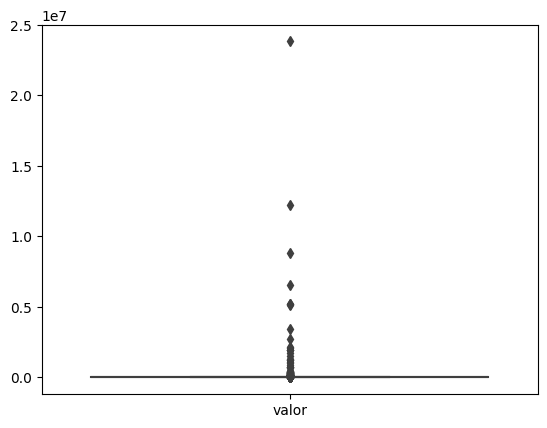

In [996]:
import seaborn as sns

ax = sns.boxplot(data=df[['valor']])

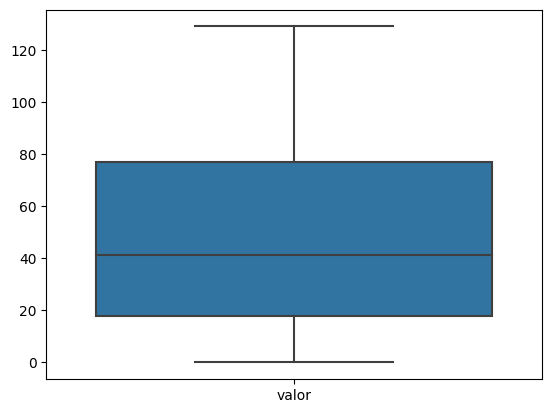

In [997]:
# Remover valores outliers
df = df.loc[df['valor'] < 130]

# Novo boxplot
ax = sns.boxplot(data=df[['valor']])

Verificar linhas que possuem valores NaN

In [998]:
df.isna().sum()

unidade_requisitante    0
convenio                0
status                  0
almoxarifado            0
valor                   0
dtype: int64

O proximo passo é categorizar as colunas dos valores baseando-se pelo box plot apresentado anteriormente

In [999]:
def categorize_value(value):
    # 0 = valores abaixo R$ 20
    if value < 20:
        return 0
    # 1 = valores entre R$ 20 e R$ 60
    elif value >= 20 and value <= 60:
        return 1
    # 2 = valores maiores que R$ 60
    return 2

df.loc[:,'valor'] = df['valor'].apply(categorize_value)

Para ter uma noção do balanceamento dos dados, abaixo é possível ver quantas requisições foram negadas (status 0) e quantas foram aprovadas (status 1)

In [1000]:
df['status'].value_counts()

status
1    125
0    105
Name: count, dtype: int64

## Aplicação da Árvore de Decisão

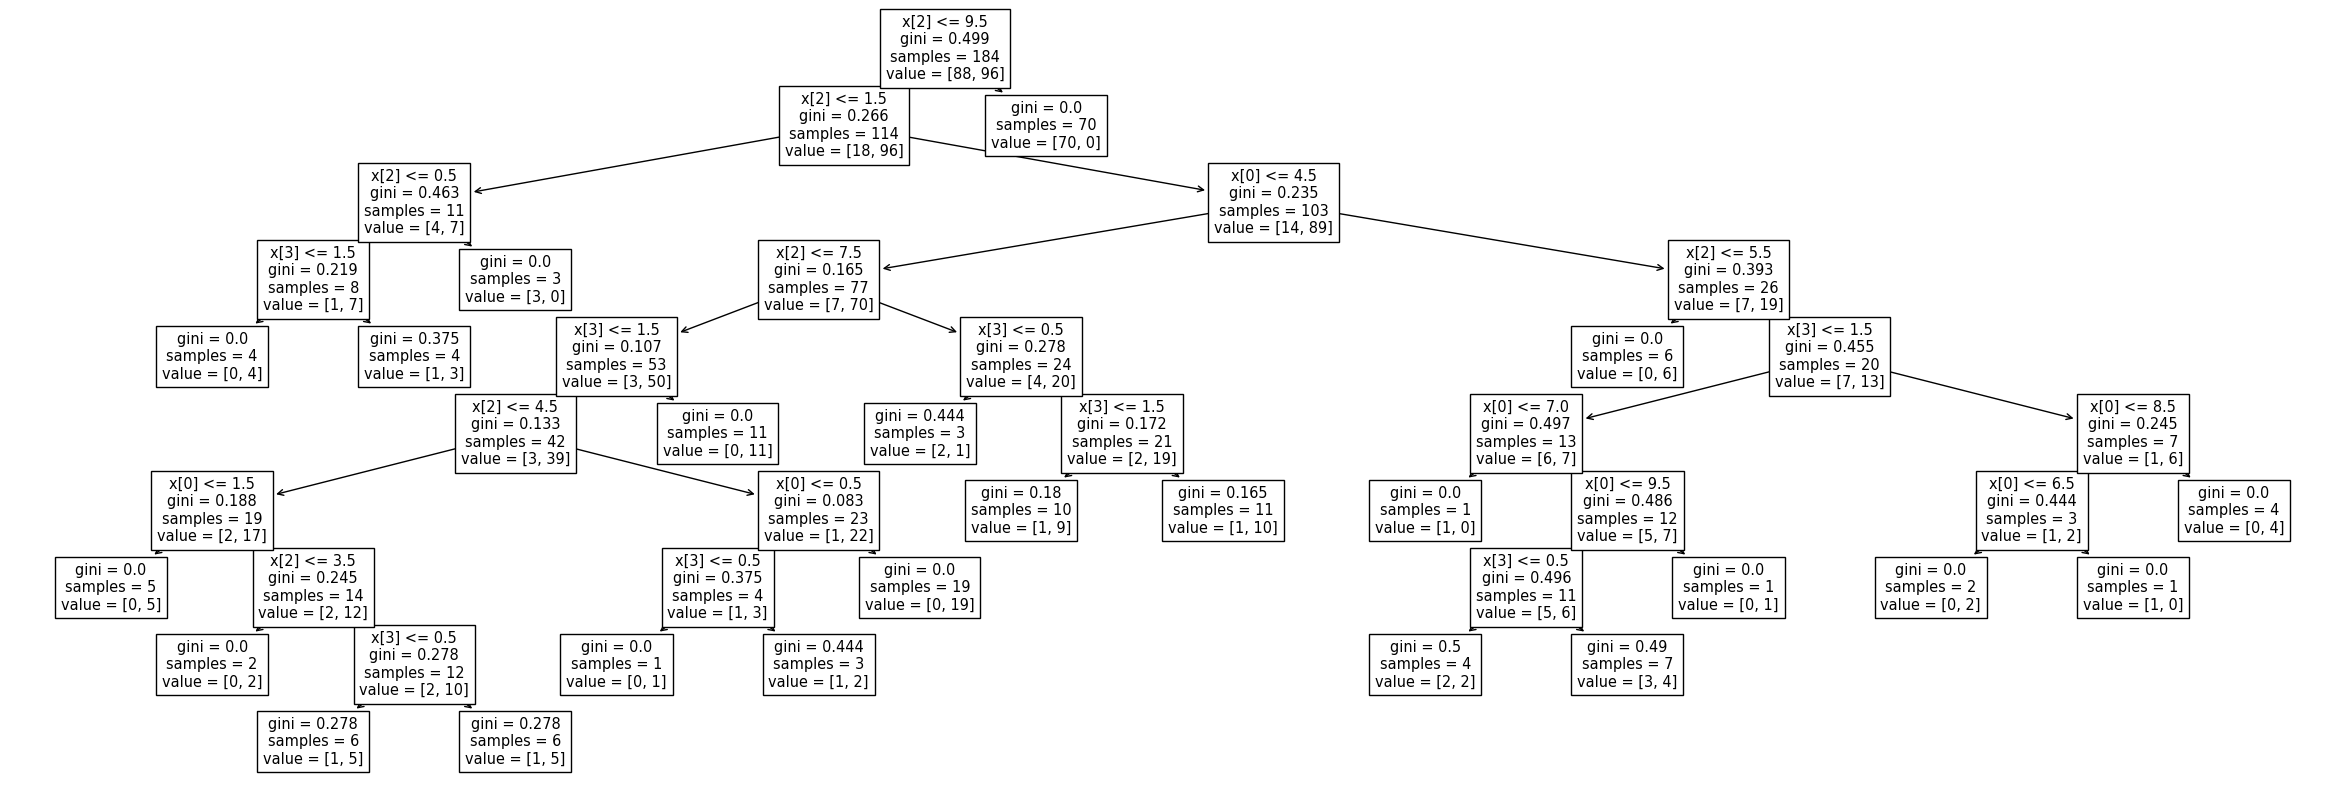

In [1001]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn import tree

# Separando X (features) e y (label)
X = df.drop('status',axis=1)
y = df.status

# Divisao treino e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Montar classificador
clf = DecisionTreeClassifier()

# Treinar o classificador
clf = clf.fit(X_train, y_train)

# Visualizar decisões
fig, ax = plt.subplots(figsize=(30,10))
tree.plot_tree(clf)
plt.show()

Score:  0.9347826086956522


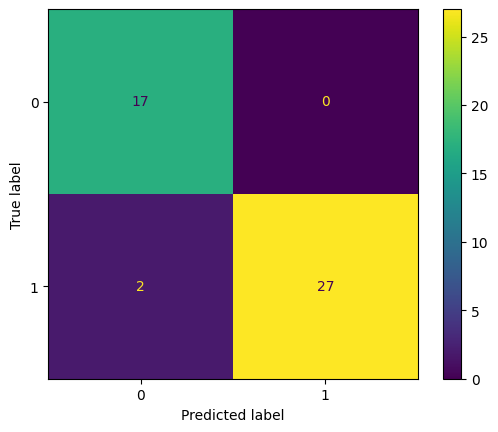

In [1002]:
# Verificar score com dados de treino
print('Score: ', clf.score(X_train, y_train))

# Faça a predição
y_pred = clf.predict(X_test)

# Matriz de confusao
cm = confusion_matrix(y_test,y_pred)

# Plot da matriz de confusao
cm_display = ConfusionMatrixDisplay(cm).plot()